In [5]:
## Notebook env: archr (R kernel)
## This notebook starts requires archr_obtaining_chromatin_matrices.ipynb, CRISPRi_CV_analysis.ipynb, CRISPRa_CV_analysis.ipynb, CRISPRi_pseudobulk_meta_aka_mean_changes_analysis.ipynb, CRISPRa_pseudobulk_meta_aka_mean_changes_analysis.ipynb to be run first

In [1]:
suppressMessages(suppressWarnings(library(ArchR)))
set.seed(1)
suppressMessages(suppressWarnings(library(tidyverse)))
suppressMessages(suppressWarnings(library(ggpubr)))

In [2]:
CRISPRi_CVs = readRDS('/home/ssobti/projects/heterogeneity_brian/output_data/scATACseq/091724_BW/post_archr_analysis/CRISPRi_CVs.rds')
CRISPRa_CVs = readRDS('/home/ssobti/projects/heterogeneity_brian/output_data/scATACseq/091724_BW/post_archr_analysis/CRISPRa_CVs.rds')
CRISPRi_means = readRDS('/home/ssobti/projects/heterogeneity_brian/output_data/scATACseq/091724_BW/post_archr_analysis/CRISPRi_means.rds')
CRISPRa_means = readRDS('/home/ssobti/projects/heterogeneity_brian/output_data/scATACseq/091724_BW/post_archr_analysis/CRISPRa_means.rds')

In [3]:
CRISPRi_CVs_means = mapply(CRISPRi_CVs[c('RNF8-Ci', 'MIS18A-Ci')], CRISPRi_means[c('RNF8-Ci', 'MIS18A-Ci')], FUN = function(x,y) cbind(x, mean_gd = y$mean), SIMPLIFY = F)
CRISPRa_CVs_means = mapply(CRISPRa_CVs[c('RNF8-Ca', 'MIS18A-Ca')], CRISPRa_means[c('RNF8-Ca', 'MIS18A-Ca')], FUN = function(x,y) cbind(x, mean_gd = y$mean), SIMPLIFY = F)

In [4]:
savepath = '/home/ssobti/projects/heterogeneity_brian/output_data/scATACseq/091724_BW/archr_analysis'
setwd(savepath)
addArchRThreads(threads = 35)
addArchRGenome("hg38")
addArchRLocking(locking = TRUE)

txnhet_archr_macs2_project <- loadArchRProject(savepath)

## rename samples in new column to preserve order in plotBrowserTrack
df = data.frame(getCellColData(txnhet_archr_macs2_project))

renamed_names = plyr::mapvalues(df$Sample, from = c('MIS18A-Ca-1', 'MIS18A-Ca-2', 'MIS18A-Ci-1', 'MIS18A-Ci-2', 'NTCa-1', 'NTCa-2', 'NTCi-1', 'NTCi-2', 'RNF8-Ca-1', 'RNF8-Ca-2', 'RNF8-Ci-1', 'RNF8-Ci-2'), 
    to = c('3_MIS18A-Ca-1', '4_MIS18A-Ca-2', '3_MIS18A-Ci-1', '4_MIS18A-Ci-2', '1_NTCa-1', '2_NTCa-2', '1_NTCi-1', '2_NTCi-2', '3_RNF8-Ca-1', '4_RNF8-Ca-2', '3_RNF8-Ci-1', '4_RNF8-Ci-2'))

renamed_combined_names = plyr::mapvalues(stringr::str_sub(df$Sample, end = -3), from = c('MIS18A-Ca', 'MIS18A-Ci', 'NTCa', 'NTCi', 'RNF8-Ca', 'RNF8-Ci'), 
    to = c('2_MIS18A-Ca', '2_MIS18A-Ci', '1_NTCa', '1_NTCi', '2_RNF8-Ca', '2_RNF8-Ci'))

txnhet_archr_macs2_project$renamed_samples = renamed_names
txnhet_archr_macs2_project$renamed_combined_lanes_samples = renamed_combined_names

## subset the data so only 1000 known cells displayed
meta = data.frame(getCellColData(txnhet_archr_macs2_project))
cellnames = split(rownames(meta), f = meta$renamed_samples)
set.seed(1)
cellnames = lapply(cellnames, function(x) sample(x, size = 1000, replace = F))
cellnames = unlist(cellnames,use.names = F)
subset_txnhet_archr_macs2_project = subsetCells(ArchRProj = txnhet_archr_macs2_project, cellNames = cellnames)


### tile matrix that the plotBrowserTrack uses ###
tile = getMatrixFromProject(subset_txnhet_archr_macs2_project, useMatrix = 'TileMatrix', binarize = T)
tile_mtx = tile@assays@data@listData$TileMatrix
tile_cell_meta = data.frame(colData(tile))
tile_region_meta = data.frame(rowData(tile))

## get gene annotation ##
gene_annot = getGeneAnnotation(subset_txnhet_archr_macs2_project)
gene_annot = gene_annot[['genes']] %>% as.data.frame()
tile_region_meta$index = rownames(tile_region_meta)

Setting default number of Parallel threads to 35.

Setting default genome to Hg38.

Setting ArchRLocking to TRUE.



Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

## CRISPRi examples ##

#### RNF8-Ci ####

In [31]:
CRISPRi_CVs_means[['RNF8-Ci']] %>% filter(abs(mean_gdmean_ctrlratio - 1) < 0.01) %>% arrange(CV_gdCV_ctrlratio) %>% head()

,gene,CV_ctrl,CV_gd,CV_gdCV_ctrlratio,mean_gdmean_ctrlratio,gene_status,p_val,mean_gd
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,RUNX1,3.054664,1.256026,0.4111831,1.0067070,Decreasing,0.000000e+00,1.0402572
2,NR3C2,3.774479,1.650698,0.4373315,0.9907658,Decreasing,1.638854e-259,0.5474068
3,DAP3,3.703310,1.861220,0.5025828,0.9984817,Decreasing,8.256784e-155,0.4591183
4,ARHGEF12,3.643166,1.861206,0.5108760,1.0048200,Decreasing,1.316762e-148,0.4998579
5,MACROD2,3.004428,1.552890,0.5168671,0.9984288,Decreasing,7.674953e-199,0.7516684
6,PPP4R3A,4.020650,2.091826,0.5202707,1.0068100,Decreasing,1.101490e-114,0.3987320


In [32]:
sctrack <- plotBrowserTrack(ArchRProj = subset_txnhet_archr_macs2_project, groupBy = "renamed_combined_lanes_samples", 
    plotSummary = c("scTrack", "featureTrack", "loopTrack", "geneTrack"), geneSymbol = c('RUNX1', 'NR3C2'), 
    useGroups = c('1_NTCi', '2_RNF8-Ci'), upstream = 400000, downstream = 100000, scCellsMax = 2000)

bulktrack <- plotBrowserTrack(ArchRProj = subset_txnhet_archr_macs2_project, groupBy = "renamed_combined_lanes_samples", 
    plotSummary = c("bulkTrack", "featureTrack", "loopTrack", "geneTrack"), geneSymbol = c('RUNX1', 'NR3C2'), 
    useGroups = c('1_NTCi', '2_RNF8-Ci'), upstream = 400000, downstream = 100000, scCellsMax = 2000)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-32f8057664ee76-Date-2025-03-04_Time-14-04-07.963011.log
If there is an issue, please report to github with logFile!



2025-03-04 14:04:08.137721 : Validating Region, 0.003 mins elapsed.



GRanges object with 2 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]    chr21   34787801-35049344      - |         861       RUNX1
  [2]     chr4 148078762-148444698      - |        4306       NR3C2
  -------
  seqinfo: 24 sequences from hg38 genome


2025-03-04 14:04:08.290611 : Adding SC Tracks (1 of 2), 0.005 mins elapsed.

2025-03-04 14:04:09.969181 : Adding Feature Tracks (1 of 2), 0.033 mins elapsed.

2025-03-04 14:04:10.063434 : Adding Gene Tracks (1 of 2), 0.035 mins elapsed.

2025-03-04 14:04:10.413879 : Plotting, 0.041 mins elapsed.

2025-03-04 14:04:11.324877 : Adding SC Tracks (2 of 2), 0.056 mins elapsed.

2025-03-04 14:04:13.191281 : Adding Feature Tracks (2 of 2), 0.087 mins elapsed.

2025-03-04 14:04:13.285218 : Adding Gene Tracks (2 of 2), 0.089 mins elapsed.

2025-03-04 14:04:13.652963 : Plotting, 0.095 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-32f8057664ee76-Date-2025-03-04_Time-14-04-07.963011.log

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-32f8056efa398d-Date-2025-03-04_Time-14-04-14.333421.log
If there is an issue, please report to github with logFile!

2025-03-04 14:04:14.488658 : Validating Region, 0.003 mins elapsed.



GRanges object with 2 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]    chr21   34787801-35049344      - |         861       RUNX1
  [2]     chr4 148078762-148444698      - |        4306       NR3C2
  -------
  seqinfo: 24 sequences from hg38 genome


2025-03-04 14:04:14.60127 : Adding Bulk Tracks (1 of 2), 0.004 mins elapsed.

2025-03-04 14:04:16.284387 : Adding Feature Tracks (1 of 2), 0.033 mins elapsed.

2025-03-04 14:04:16.401091 : Adding Gene Tracks (1 of 2), 0.034 mins elapsed.

2025-03-04 14:04:16.833026 : Plotting, 0.042 mins elapsed.

2025-03-04 14:04:17.984529 : Adding Bulk Tracks (2 of 2), 0.061 mins elapsed.

2025-03-04 14:04:19.753627 : Adding Feature Tracks (2 of 2), 0.09 mins elapsed.

2025-03-04 14:04:19.874456 : Adding Gene Tracks (2 of 2), 0.092 mins elapsed.

2025-03-04 14:04:20.569898 : Plotting, 0.104 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-32f8056efa398d-Date-2025-03-04_Time-14-04-14.333421.log



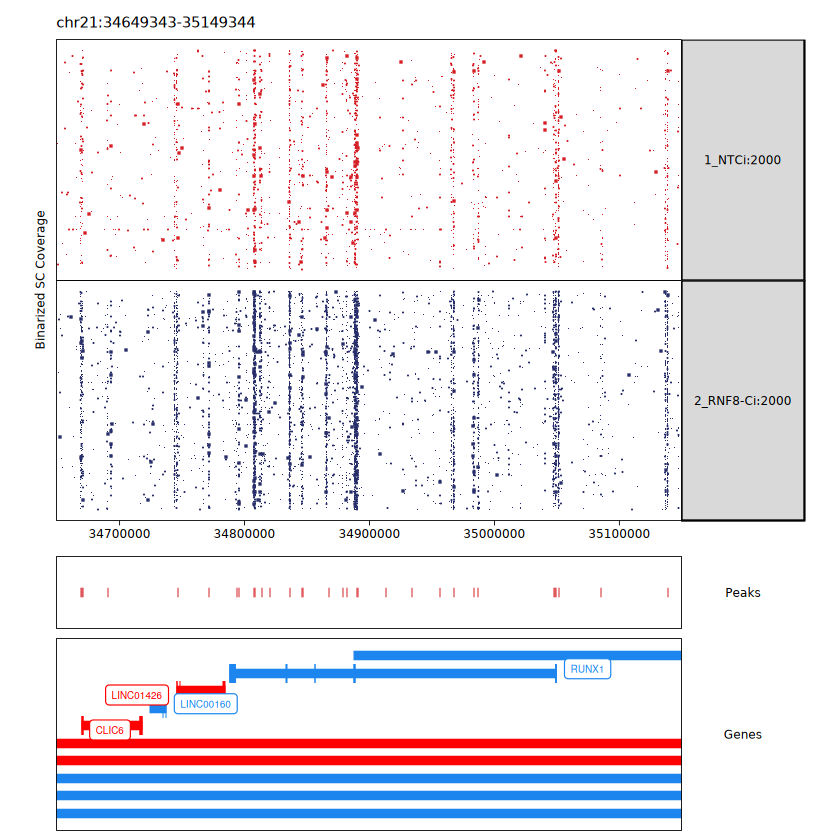

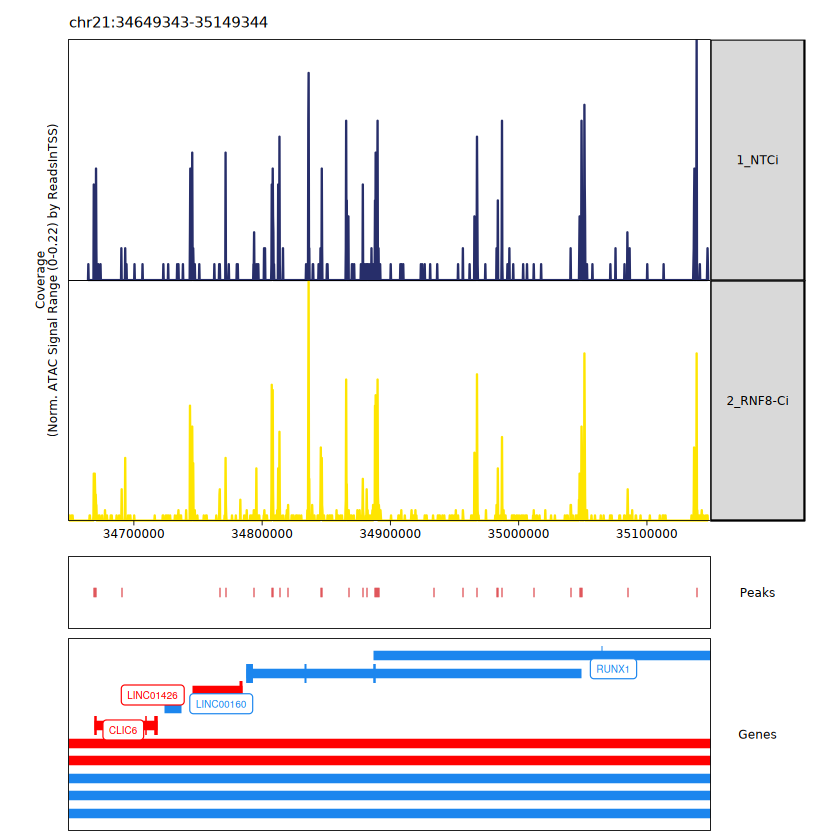

In [38]:
options(repr.plot.width=7, repr.plot.height=7)
grid::grid.newpage()
grid::grid.draw(sctrack$RUNX1)
grid::grid.newpage()
grid::grid.draw(bulktrack$RUNX1)

In [34]:
pdf('/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/NR3C2_rnf8_ci_track.pdf', width = 7, height = 7)
grid::grid.newpage()
grid::grid.draw(sctrack$NR3C2)
dev.off()

pdf 
  2

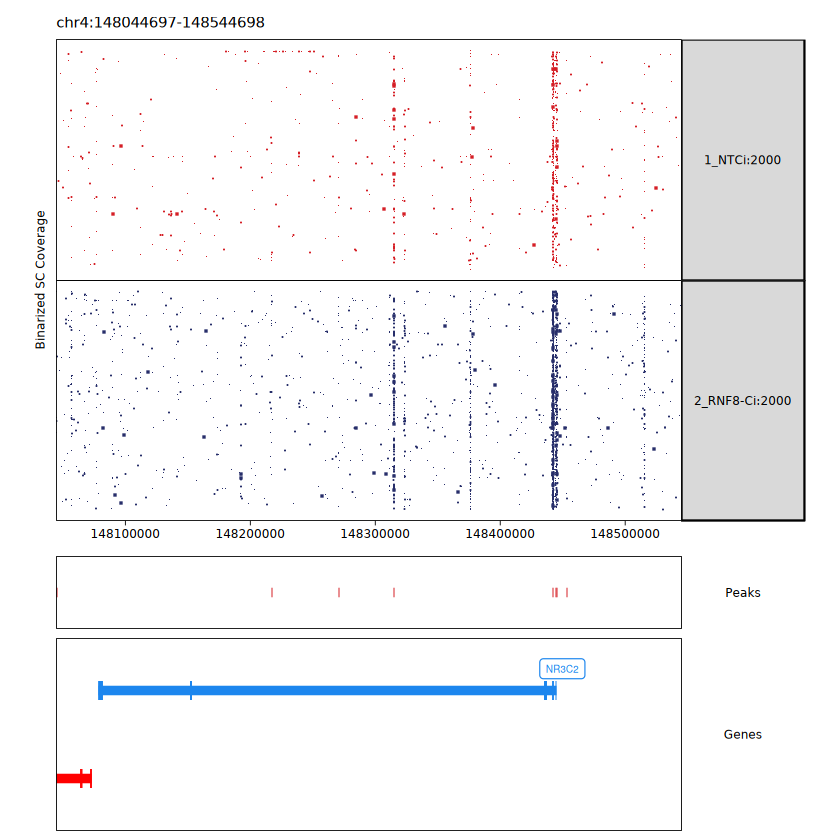

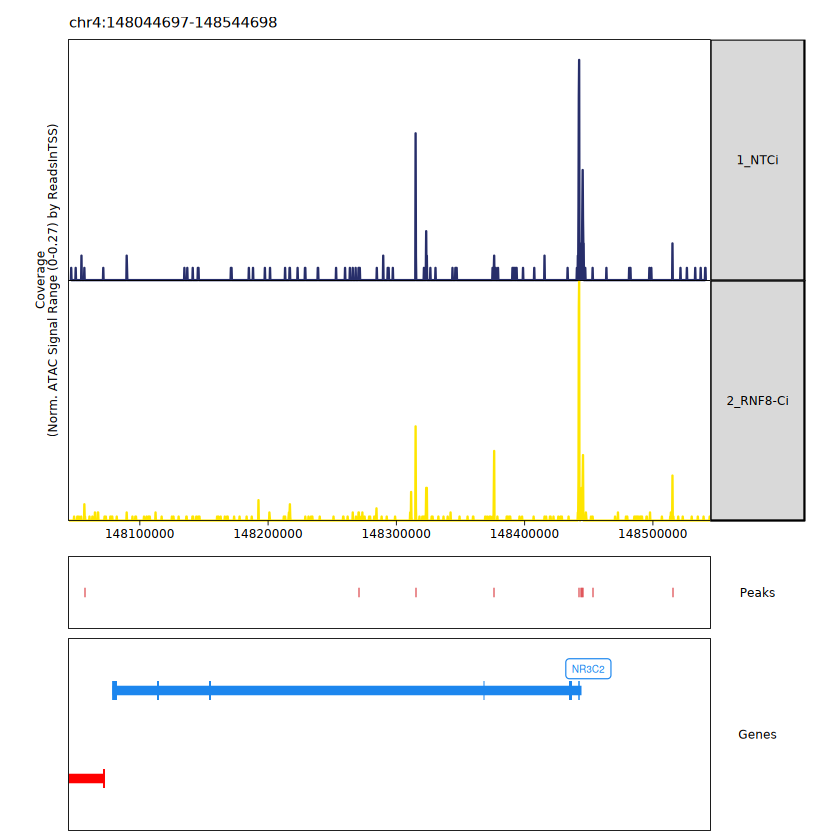

In [35]:
options(repr.plot.width=7, repr.plot.height=7)
grid::grid.newpage()
grid::grid.draw(sctrack$NR3C2)
grid::grid.newpage()
grid::grid.draw(bulktrack$NR3C2)

Warning message in geom_bar(aes(fill = sample), stat = "summary", fun.y = "mean", :
“Ignoring unknown parameters: `fun.y`”
No summary function supplied, defaulting to `mean_se()`


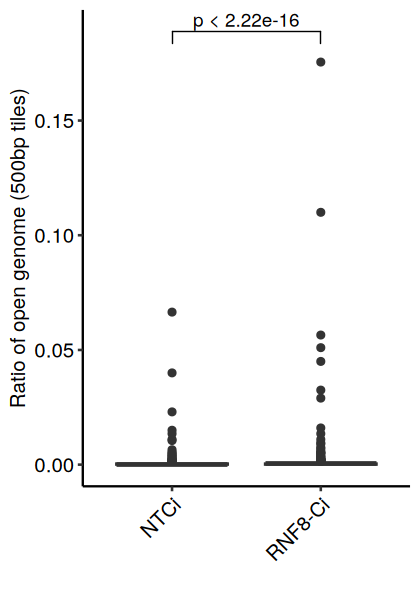

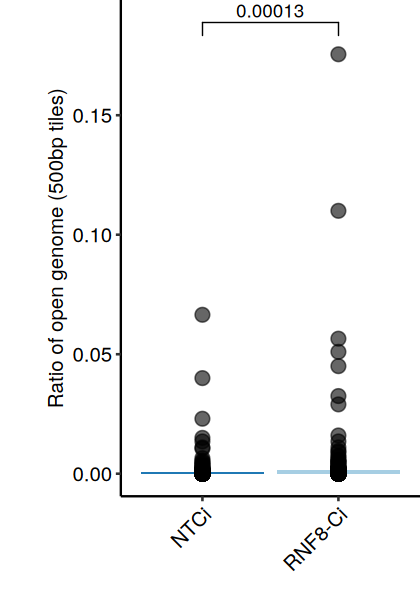

In [36]:
gene_coord = gene_annot %>% filter(symbol %in% 'NR3C2')
coord_idx = tile_region_meta %>% filter((seqnames %in% as.character(gene_coord$seqnames)) & (start > (gene_coord$start - 500)) & (start < (gene_coord$end + 500))) %>% pull(index) %>% as.numeric()
cell_idx = rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% c('1_NTCi', '2_RNF8-Ci'),])
NR3C2_mtx = tile_mtx[coord_idx, cell_idx]

## table of ratios of 0 to 1 for each 500 bp bin ##
df = data.frame('NTCi' = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '1_NTCi',])])/2000, 
'RNF8-Ci' = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '2_RNF8-Ci',])])/2000)
colnames(df) = c('NTCi', 'RNF8-Ci')

plot_df = pivot_longer(df, cols = everything(), names_to = 'sample', values_to = 'ratio')
plot_df$sample = factor(plot_df$sample, levels = c('NTCi', 'RNF8-Ci'))

options(repr.plot.width = 3.5, repr.plot.height = 5)
## plot 0 to 1 ratio boxplot ##
plot_df %>% ggplot(aes(x = sample, y = ratio)) + geom_boxplot() + 
 stat_compare_means(comparisons = list(c('NTCi', 'RNF8-Ci')), method = 'wilcox', paired = T, label.y = 0.18) + xlab('') + 
 ylab('Ratio of open genome (500bp tiles)') + theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1))

plot_df %>% ggplot(aes(sample, ratio)) + geom_bar(aes(fill = sample), stat = 'summary', fun.y = 'mean', show.legend = FALSE) +
    geom_point(color = 'black', alpha = 0.6, size = 3.5, show.legend = FALSE) + theme_pubr() + stat_compare_means(comparisons = list(c('NTCi', 'RNF8-Ci')), method = 't.test', paired = T, label.y = 0.18) +
    theme(plot.margin = unit(c(0, 0, 0, 0.4), 'in'), plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + 
    xlab('') + ylab('Ratio of open genome (500bp tiles)') + scale_fill_brewer(palette = 'Paired', direction = -1) + scale_color_brewer(palette = 'Paired', direction = -1)

[1] 729

[1] 0.993188

[1] 0.1755

[1] 0.0665

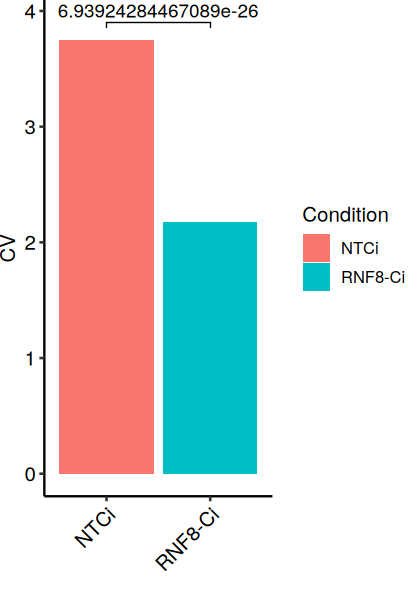

In [37]:
peaksums_RNF8_Ci = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '2_RNF8-Ci',])])
which.max(peaksums_RNF8_Ci)
which.max(peaksums_RNF8_Ci)/length(peaksums_RNF8_Ci) ## peak is at 99% starting from the left side of the gene
peaksums_RNF8_Ci[which.max(peaksums_RNF8_Ci)]/2000 ## open to close ratio

peaksums_NTCi = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '1_NTCi',])])
peaksums_NTCi[which.max(peaksums_RNF8_Ci)]/2000 ## open to close ratio

max_peak_df = data.frame(Condition = c('RNF8-Ci', 'RNF8-Ci', 'NTCi', 'NTCi'), chromatin = c('open', 'closed', 'open', 'closed'), pct = c(peaksums_RNF8_Ci[which.max(peaksums_RNF8_Ci)]/2000, 1 - peaksums_RNF8_Ci[which.max(peaksums_RNF8_Ci)]/2000, peaksums_NTCi[which.max(peaksums_RNF8_Ci)]/2000, 1 - peaksums_NTCi[which.max(peaksums_RNF8_Ci)]/2000))
max_peak_df$Condition = factor(max_peak_df$Condition, levels = c('NTCi', 'RNF8-Ci'))

stat.test = tibble(
  group1 = 'NTCi',
  group2 = 'RNF8-Ci',
  p.adj = chisq.test(matrix(c(max_peak_df$pct[1:2], max_peak_df$pct[3:4]), nrow = 2) * 2000)$p.value, ## chi-squared test
  y.position = 3.9
)
mtx = matrix(c(max_peak_df$pct[1:2], max_peak_df$pct[3:4]), nrow = 2) * 2000
df = data.frame(Condition = c('NTCi', 'RNF8-Ci'), CV = c(sd(c(rep(1, mtx[1,2]), c(rep(0, mtx[2,2]))))/mean(c(rep(1, mtx[1,2]), c(rep(0, mtx[2,2])))), sd(c(rep(1, mtx[1,1]), c(rep(0, mtx[2,1]))))/mean(c(rep(1, mtx[1,1]), c(rep(0, mtx[2,1]))))))
df$Condition = factor(df$Condition, levels = c('NTCi', 'RNF8-Ci'))
ggplot(df, aes(fill = Condition, y = CV, x = Condition)) + 
    geom_bar(position = "fill", stat = "identity", show.legend = T) + geom_bar(stat="identity") + theme_pubr() + stat_pvalue_manual(stat.test, label = 'p.adj', tip.length = 0.025, inherit.aes = F) +
    theme(legend.position = "right", axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + xlab('') + ylab('CV') + 
    theme(plot.margin = unit(c(0, 0, 0, 0), "in"), plot.title = element_text(hjust = 0.5, family = "Helvetica"), axis.text.x = element_text(family = "Helvetica"), axis.title = element_text(family = "Helvetica"), legend.text = element_text(family = "Helvetica"), legend.title = element_text(family = "Helvetica"))

saveRDS(df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/NR3C2_rnf8_ci_track_barplot_df.rds')
saveRDS(stat.test, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/NR3C2_rnf8_ci_track_barplot_test.rds')

#### MIS18A-Ci ####

In [39]:
CRISPRi_CVs_means[['MIS18A-Ci']] %>% filter(abs(mean_gdmean_ctrlratio - 1) < 0.01) %>% arrange(CV_gdCV_ctrlratio) %>% head()

,gene,CV_ctrl,CV_gd,CV_gdCV_ctrlratio,mean_gdmean_ctrlratio,gene_status,p_val,mean_gd
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,STAT3,3.272616,1.779141,0.5436448,1.0095717,Decreasing,2.354998e-81,0.7960551
2,TMEM248,3.874999,2.446346,0.6313154,0.9994536,Decreasing,2.315165e-30,0.4131250
3,ABCB7,7.844616,5.157486,0.6574555,0.9964803,Decreasing,2.639499e-07,0.0724060
4,CLINT1,4.225886,2.793075,0.6609442,1.0090189,Decreasing,1.996079e-20,0.2344541
5,SSBP2,2.597767,1.762039,0.6782898,1.0075349,Decreasing,2.394844e-41,0.6527159
6,UBE2G1,3.200612,2.171272,0.6783928,0.9965969,Decreasing,9.502031e-29,0.4693622


In [40]:
sctrack <- plotBrowserTrack(ArchRProj = subset_txnhet_archr_macs2_project, groupBy = "renamed_combined_lanes_samples", 
    plotSummary = c("scTrack", "featureTrack", "loopTrack", "geneTrack"), geneSymbol = c('STAT3', 'TMEM248'), 
    useGroups = c('1_NTCi', '2_MIS18A-Ci'), upstream = 15000, downstream = 50000, scCellsMax = 2000)
    
bulktrack <- plotBrowserTrack(ArchRProj = subset_txnhet_archr_macs2_project, groupBy = "renamed_combined_lanes_samples", 
    plotSummary = c("bulkTrack", "featureTrack", "loopTrack", "geneTrack"), geneSymbol = c('STAT3', 'TMEM248'), 
    useGroups = c('1_NTCi', '2_MIS18A-Ci'), upstream = 15000, downstream = 50000, scCellsMax = 2000)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-32f8057f8b87a7-Date-2025-03-04_Time-14-05-04.582254.log
If there is an issue, please report to github with logFile!



2025-03-04 14:05:04.701284 : Validating Region, 0.002 mins elapsed.



GRanges object with 2 ranges and 2 metadata columns:
      seqnames            ranges strand |     gene_id      symbol
         <Rle>         <IRanges>  <Rle> | <character> <character>
  [1]    chr17 42313324-42388568      - |        6774       STAT3
  [2]     chr7 66921225-66958551      + |       55069     TMEM248
  -------
  seqinfo: 24 sequences from hg38 genome


2025-03-04 14:05:04.782592 : Adding SC Tracks (1 of 2), 0.003 mins elapsed.

2025-03-04 14:05:06.08183 : Adding Feature Tracks (1 of 2), 0.025 mins elapsed.

2025-03-04 14:05:06.16466 : Adding Gene Tracks (1 of 2), 0.026 mins elapsed.

2025-03-04 14:05:06.487806 : Plotting, 0.032 mins elapsed.

2025-03-04 14:05:06.891673 : Adding SC Tracks (2 of 2), 0.039 mins elapsed.

2025-03-04 14:05:08.347694 : Adding Feature Tracks (2 of 2), 0.063 mins elapsed.

2025-03-04 14:05:08.438818 : Adding Gene Tracks (2 of 2), 0.064 mins elapsed.

2025-03-04 14:05:08.766929 : Plotting, 0.07 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-32f8057f8b87a7-Date-2025-03-04_Time-14-05-04.582254.log

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-32f8051f1a9f33-Date-2025-03-04_Time-14-05-09.206893.log
If there is an issue, please report to github with logFile!

2025-03-04 14:05:09.316621 : Validating Region, 0.002 mins elapsed.



GRanges object with 2 ranges and 2 metadata columns:
      seqnames            ranges strand |     gene_id      symbol
         <Rle>         <IRanges>  <Rle> | <character> <character>
  [1]    chr17 42313324-42388568      - |        6774       STAT3
  [2]     chr7 66921225-66958551      + |       55069     TMEM248
  -------
  seqinfo: 24 sequences from hg38 genome


2025-03-04 14:05:09.401449 : Adding Bulk Tracks (1 of 2), 0.003 mins elapsed.

2025-03-04 14:05:10.584592 : Adding Feature Tracks (1 of 2), 0.023 mins elapsed.

2025-03-04 14:05:10.672334 : Adding Gene Tracks (1 of 2), 0.024 mins elapsed.

2025-03-04 14:05:10.985734 : Plotting, 0.03 mins elapsed.

2025-03-04 14:05:11.750051 : Adding Bulk Tracks (2 of 2), 0.042 mins elapsed.

2025-03-04 14:05:13.138048 : Adding Feature Tracks (2 of 2), 0.066 mins elapsed.

2025-03-04 14:05:13.222561 : Adding Gene Tracks (2 of 2), 0.067 mins elapsed.

2025-03-04 14:05:13.550243 : Plotting, 0.072 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-32f8051f1a9f33-Date-2025-03-04_Time-14-05-09.206893.log



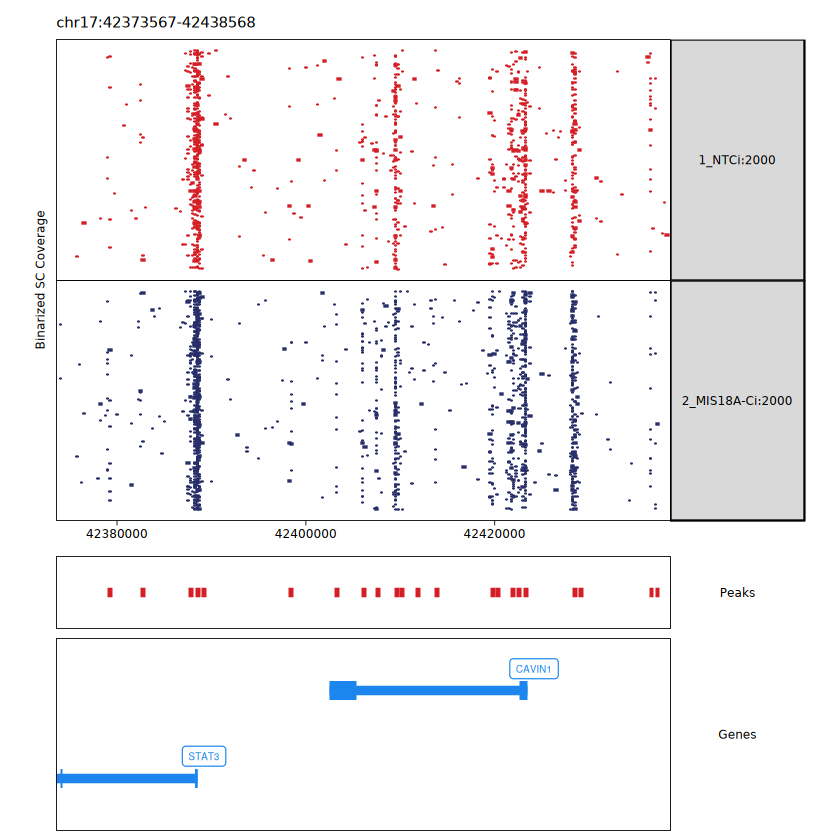

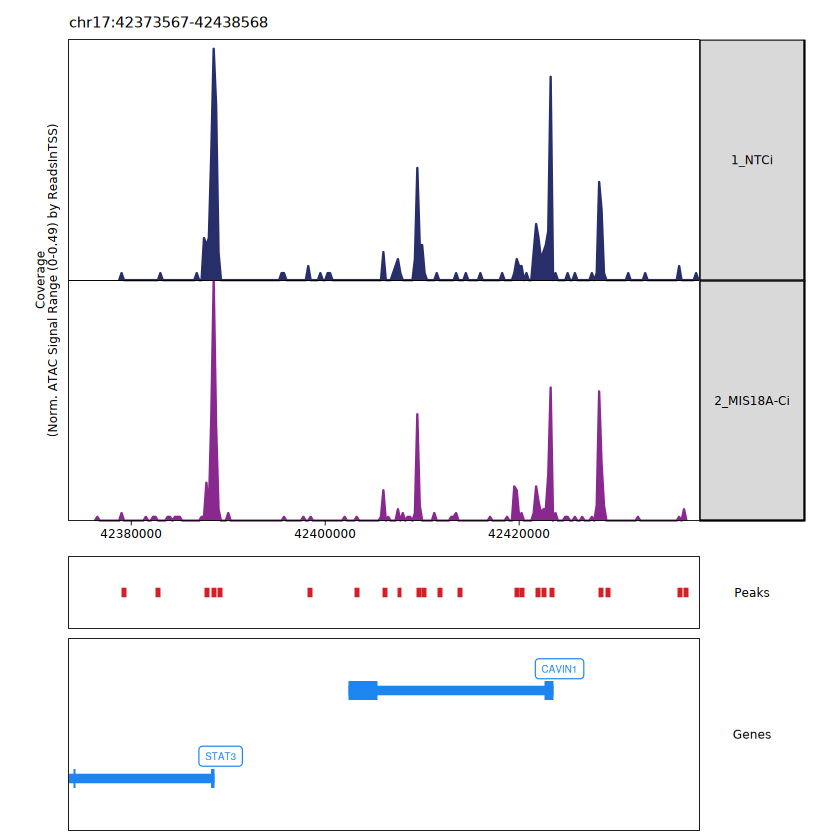

In [41]:
options(repr.plot.width=7, repr.plot.height=7)
grid::grid.newpage()
grid::grid.draw(sctrack$STAT3)
grid::grid.newpage()
grid::grid.draw(bulktrack$STAT3)

In [42]:
pdf('/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/TMEM248_mis18a_ci_track.pdf', width = 7, height = 7)
grid::grid.newpage()
grid::grid.draw(sctrack$TMEM248)
dev.off()

pdf 
  2

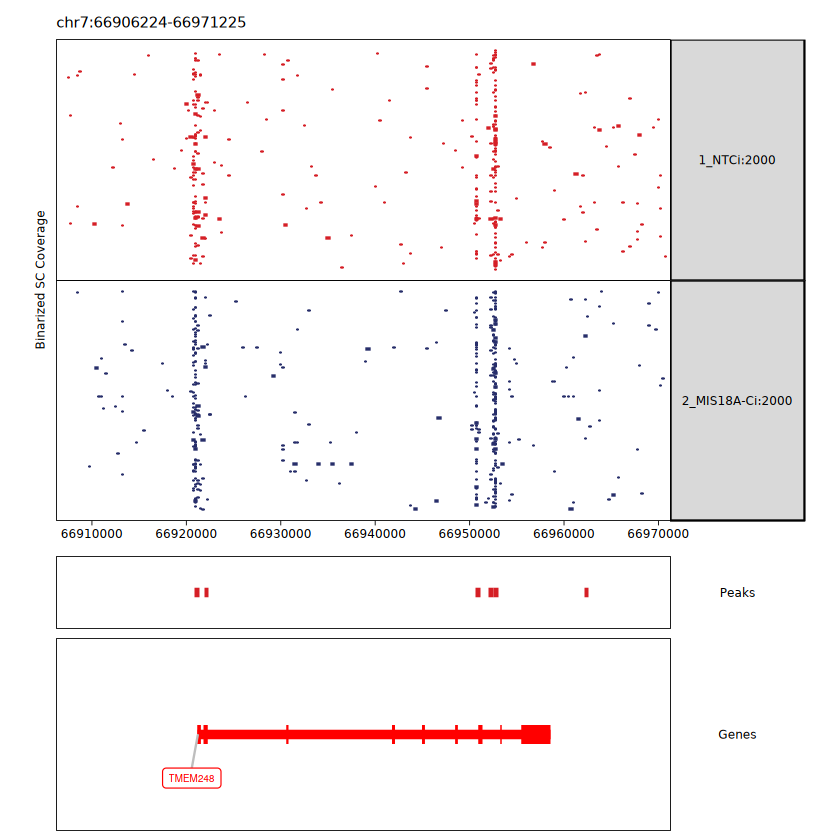

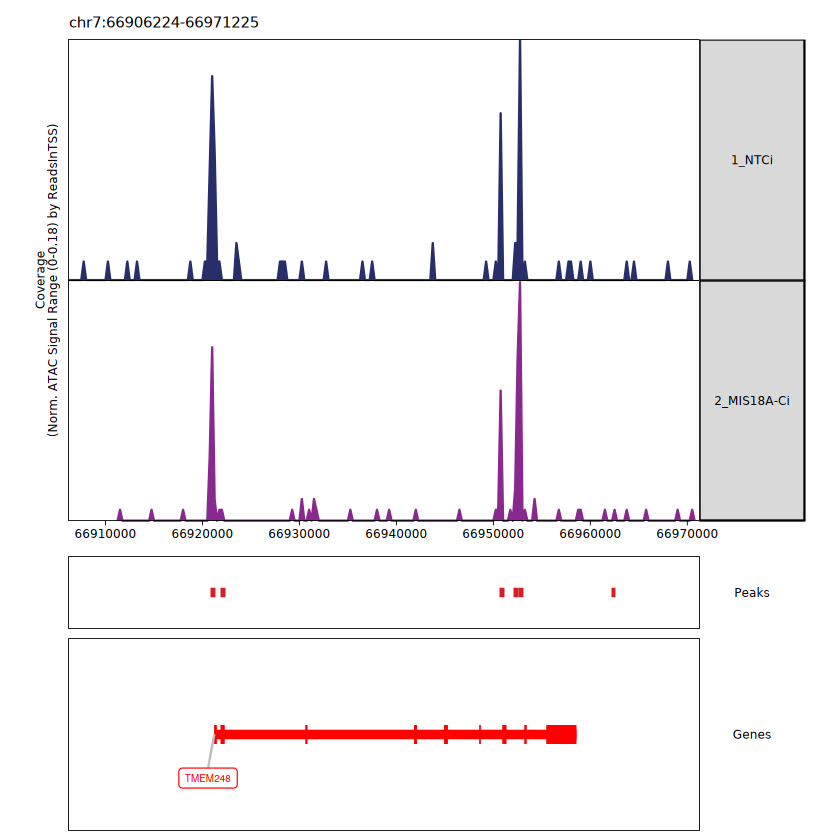

In [43]:
options(repr.plot.width=7, repr.plot.height=7)
options(repr.plot.width = 7, repr.plot.height = 7)
grid::grid.newpage()
grid::grid.draw(sctrack$TMEM248)
grid::grid.newpage()
grid::grid.draw(bulktrack$TMEM248)

Warning message in geom_bar(aes(fill = sample), stat = "summary", fun.y = "mean", :
“Ignoring unknown parameters: `fun.y`”
No summary function supplied, defaulting to `mean_se()`


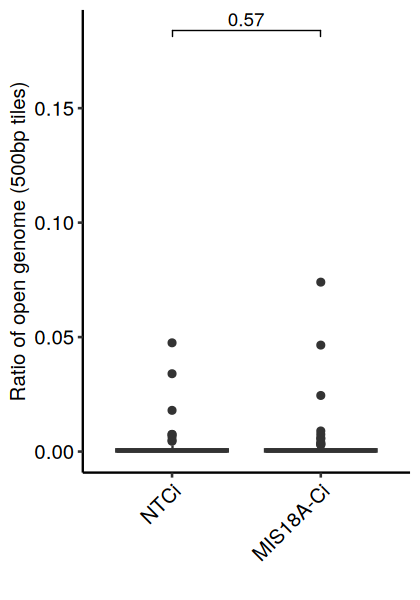

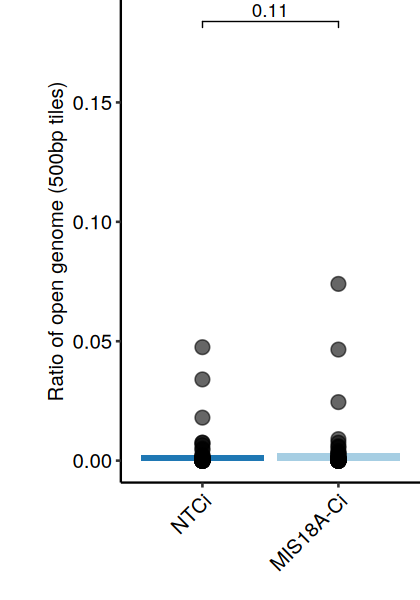

In [44]:
gene_coord = gene_annot %>% filter(symbol %in% 'TMEM248')
coord_idx = tile_region_meta %>% filter((seqnames %in% as.character(gene_coord$seqnames)) & (start > (gene_coord$start - 500)) & (start < (gene_coord$end + 500))) %>% pull(index) %>% as.numeric()
cell_idx = rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% c('1_NTCi', '2_MIS18A-Ci'),])
TMEM248_mtx = tile_mtx[coord_idx, cell_idx]

## table of ratios of 0 to 1 for each 500 bp bin ##
df = data.frame('NTCi' = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '1_NTCi',])])/2000, 
'MIS18A-Ci' = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '2_MIS18A-Ci',])])/2000)
colnames(df) = c('NTCi', 'MIS18A-Ci')

plot_df = pivot_longer(df, cols = everything(), names_to = 'sample', values_to = 'ratio')
plot_df$sample = factor(plot_df$sample, levels = c('NTCi', 'MIS18A-Ci'))

options(repr.plot.width = 3.5, repr.plot.height = 5)
## plot 0 to 1 ratio boxplot ##
plot_df %>%  ggplot(aes(x = sample, y = ratio)) + geom_boxplot() + 
 stat_compare_means(comparisons = list(c('NTCi', 'MIS18A-Ci')), method = 'wilcox', paired = T, label.y = 0.18) + xlab('') + 
 ylab('Ratio of open genome (500bp tiles)') + theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1))

plot_df %>% ggplot(aes(sample, ratio)) + geom_bar(aes(fill = sample), stat = 'summary', fun.y = 'mean', show.legend = FALSE) +
    geom_point(color = 'black', alpha = 0.6, size = 3.5, show.legend = FALSE) + theme_pubr() + stat_compare_means(comparisons = list(c('NTCi', 'MIS18A-Ci')), method = 't.test', paired = T, label.y = 0.18) +
    theme(plot.margin = unit(c(0, 0, 0, 0.4), 'in'), plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + 
    xlab('') + ylab('Ratio of open genome (500bp tiles)') + scale_fill_brewer(palette = 'Paired', direction = -1) + scale_color_brewer(palette = 'Paired', direction = -1)

[1] 64

[1] 0.8311688

[1] 0.074

[1] 0.0475

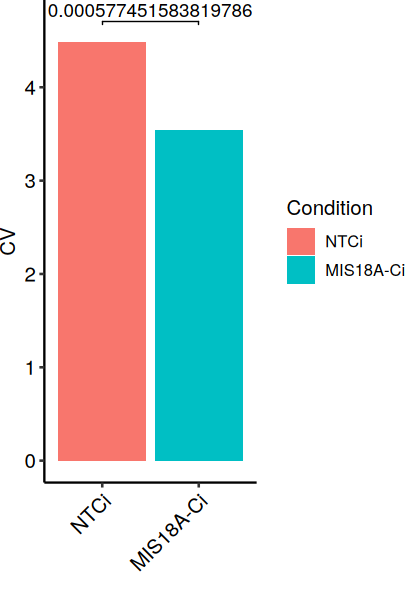

In [45]:
peaksums_MIS18A_Ci = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '2_MIS18A-Ci',])])
which.max(peaksums_MIS18A_Ci)
which.max(peaksums_MIS18A_Ci)/length(peaksums_MIS18A_Ci) ## peak is at 99% starting from the left side of the gene
peaksums_MIS18A_Ci[which.max(peaksums_MIS18A_Ci)]/2000 ## open to close ratio

peaksums_NTCi = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '1_NTCi',])])
peaksums_NTCi[which.max(peaksums_MIS18A_Ci)]/2000 ## open to close ratio

max_peak_df = data.frame(Condition = c('MIS18A-Ci', 'MIS18A-Ci', 'NTCi', 'NTCi'), chromatin = c('open', 'closed', 'open', 'closed'), pct = c(peaksums_MIS18A_Ci[which.max(peaksums_MIS18A_Ci)]/2000, 1 - peaksums_MIS18A_Ci[which.max(peaksums_MIS18A_Ci)]/2000, peaksums_NTCi[which.max(peaksums_MIS18A_Ci)]/2000, 1 - peaksums_NTCi[which.max(peaksums_MIS18A_Ci)]/2000))
max_peak_df$Condition = factor(max_peak_df$Condition, levels = c('NTCi', 'MIS18A-Ci'))

stat.test = tibble(
  group1 = 'NTCi',
  group2 = 'MIS18A-Ci',
  p.adj = chisq.test(matrix(c(max_peak_df$pct[1:2], max_peak_df$pct[3:4]), nrow = 2) * 2000)$p.value, ## chi-squared test
  y.position = 4.7
)

mtx = matrix(c(max_peak_df$pct[1:2], max_peak_df$pct[3:4]), nrow = 2) * 2000
df = data.frame(Condition = c('NTCi', 'MIS18A-Ci'), CV = c(sd(c(rep(1, mtx[1,2]), c(rep(0, mtx[2,2]))))/mean(c(rep(1, mtx[1,2]), c(rep(0, mtx[2,2])))), sd(c(rep(1, mtx[1,1]), c(rep(0, mtx[2,1]))))/mean(c(rep(1, mtx[1,1]), c(rep(0, mtx[2,1]))))))
df$Condition = factor(df$Condition, levels = c('NTCi', 'MIS18A-Ci'))
ggplot(df, aes(fill = Condition, y = CV, x = Condition)) + 
    geom_bar(position = "fill", stat = "identity", show.legend = T) + geom_bar(stat="identity") + theme_pubr() + stat_pvalue_manual(stat.test, label = 'p.adj', tip.length = 0.025, inherit.aes = F) +
    theme(legend.position = "right", axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + xlab('') + ylab('CV') + 
    theme(plot.margin = unit(c(0, 0, 0, 0), "in"), plot.title = element_text(hjust = 0.5, family = "Helvetica"), axis.text.x = element_text(family = "Helvetica"), axis.title = element_text(family = "Helvetica"), legend.text = element_text(family = "Helvetica"), legend.title = element_text(family = "Helvetica"))

saveRDS(df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/TMEM248_MIS18A_ci_track_barplot_df.rds')
saveRDS(stat.test, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/TMEM248_MIS18A_ci_track_barplot_test.rds')

## CRISPRa examples ##

#### RNF8-Ca ####

In [60]:
CRISPRa_CVs_means[['RNF8-Ca']] %>% filter(abs(mean_gdmean_ctrlratio - 1) < 0.1) %>% arrange(desc(CV_gdCV_ctrlratio)) %>% head(20)

,gene,CV_ctrl,CV_gd,CV_gdCV_ctrlratio,mean_gdmean_ctrlratio,gene_status,p_val,mean_gd
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,PRKG1,1.473648,5.152954,3.496732,1.0635779,Increasing,7.314538e-218,0.9595122
2,OSBPL8,2.172199,5.874704,2.704497,1.0750420,Increasing,5.705278e-105,0.4489620
3,NAP1L1,2.244882,5.702351,2.540156,1.0832977,Increasing,1.462187e-96,0.4841991
4,NAA16,2.954516,5.731216,1.939816,1.0205783,Increasing,2.099056e-45,0.1882375
5,CAMSAP1,1.659610,2.964160,1.786058,1.0095883,Increasing,8.693299e-115,0.6302779
6,TUBGCP3,2.659055,4.662295,1.753365,1.0234253,Increasing,1.612223e-46,0.2616908
7,TUT4,2.632729,4.569618,1.735696,1.0137558,Increasing,2.083081e-46,0.2676100
8,FXN,2.847655,4.937131,1.733753,1.0942032,Increasing,4.950939e-40,0.2676045
9,E2F7,1.819602,2.954266,1.623578,1.0382862,Increasing,8.224944e-78,0.7169433


In [61]:
sctrack <- plotBrowserTrack(ArchRProj = subset_txnhet_archr_macs2_project, groupBy = "renamed_combined_lanes_samples", 
    plotSummary = c("scTrack", "featureTrack", "loopTrack", "geneTrack"), geneSymbol = c('TRPS1', 'NR2F1-AS1'), 
    useGroups = c('1_NTCa', '2_RNF8-Ca'), upstream = 420000, downstream = 20000, scCellsMax = 2000)

bulktrack <- plotBrowserTrack(ArchRProj = subset_txnhet_archr_macs2_project, groupBy = "renamed_combined_lanes_samples", 
    plotSummary = c("bulkTrack", "featureTrack", "loopTrack", "geneTrack"), geneSymbol = c('TRPS1', 'NR2F1-AS1'), 
    useGroups = c('1_NTCa', '2_RNF8-Ca'), upstream = 420000, downstream = 20000, scCellsMax = 2000)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-32f8053868fdc3-Date-2025-03-04_Time-14-08-57.016766.log
If there is an issue, please report to github with logFile!

2025-03-04 14:08:57.129478 : Validating Region, 0.002 mins elapsed.



GRanges object with 2 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]     chr8 115408496-115809673      - |        7227       TRPS1
  [2]     chr5   93409359-93585648      - |      441094   NR2F1-AS1
  -------
  seqinfo: 24 sequences from hg38 genome


2025-03-04 14:08:57.211738 : Adding SC Tracks (1 of 2), 0.003 mins elapsed.

2025-03-04 14:08:58.879167 : Adding Feature Tracks (1 of 2), 0.031 mins elapsed.

2025-03-04 14:08:58.970934 : Adding Gene Tracks (1 of 2), 0.033 mins elapsed.

2025-03-04 14:08:59.298635 : Plotting, 0.038 mins elapsed.

2025-03-04 14:08:59.682243 : Adding SC Tracks (2 of 2), 0.044 mins elapsed.



2025-03-04 14:09:01.066087 : Adding Feature Tracks (2 of 2), 0.067 mins elapsed.

2025-03-04 14:09:01.162152 : Adding Gene Tracks (2 of 2), 0.069 mins elapsed.

2025-03-04 14:09:01.477972 : Plotting, 0.074 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-32f8053868fdc3-Date-2025-03-04_Time-14-08-57.016766.log

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-32f80526338bdf-Date-2025-03-04_Time-14-09-01.982291.log
If there is an issue, please report to github with logFile!

2025-03-04 14:09:02.087493 : Validating Region, 0.002 mins elapsed.



GRanges object with 2 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]     chr8 115408496-115809673      - |        7227       TRPS1
  [2]     chr5   93409359-93585648      - |      441094   NR2F1-AS1
  -------
  seqinfo: 24 sequences from hg38 genome


2025-03-04 14:09:02.180864 : Adding Bulk Tracks (1 of 2), 0.003 mins elapsed.

2025-03-04 14:09:03.87811 : Adding Feature Tracks (1 of 2), 0.032 mins elapsed.

2025-03-04 14:09:03.963535 : Adding Gene Tracks (1 of 2), 0.033 mins elapsed.

2025-03-04 14:09:04.295336 : Plotting, 0.039 mins elapsed.

2025-03-04 14:09:04.894743 : Adding Bulk Tracks (2 of 2), 0.049 mins elapsed.

2025-03-04 14:09:06.395718 : Adding Feature Tracks (2 of 2), 0.074 mins elapsed.

2025-03-04 14:09:06.47899 : Adding Gene Tracks (2 of 2), 0.075 mins elapsed.

2025-03-04 14:09:06.797324 : Plotting, 0.08 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-32f80526338bdf-Date-2025-03-04_Time-14-09-01.982291.log



In [62]:
pdf('/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/TRPS1_rnf8_ca_track.pdf', width = 7, height = 7)
grid::grid.newpage()
grid::grid.draw(sctrack$TRPS1)
dev.off()

pdf 
  2

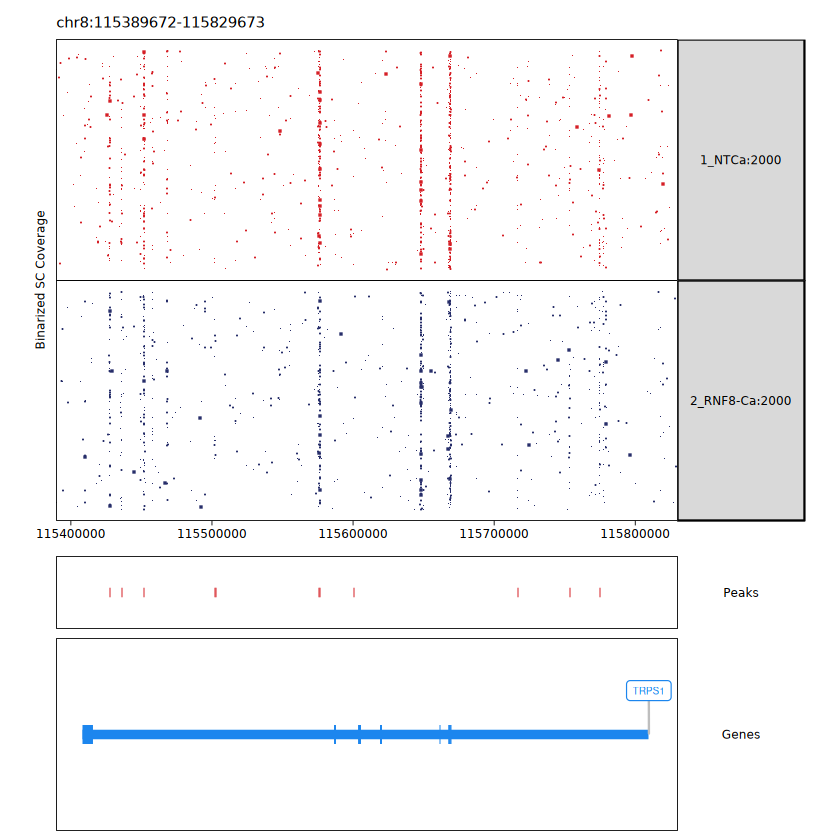

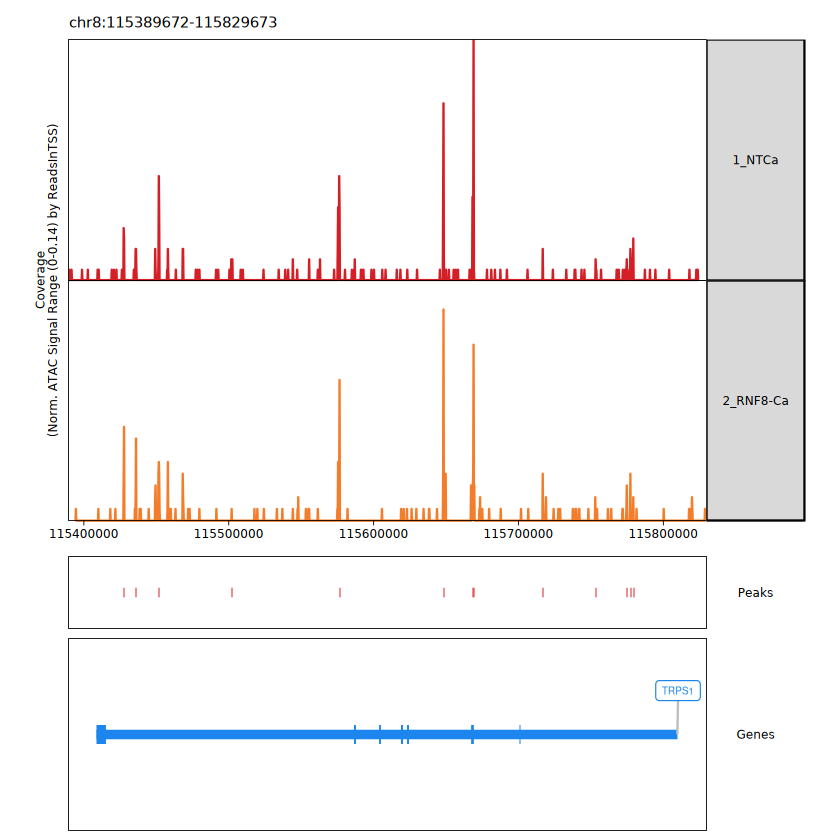

In [63]:
options(repr.plot.width = 7, repr.plot.height = 7)
grid::grid.newpage()
grid::grid.draw(sctrack$TRPS1)
grid::grid.newpage()
grid::grid.draw(bulktrack$TRPS1)

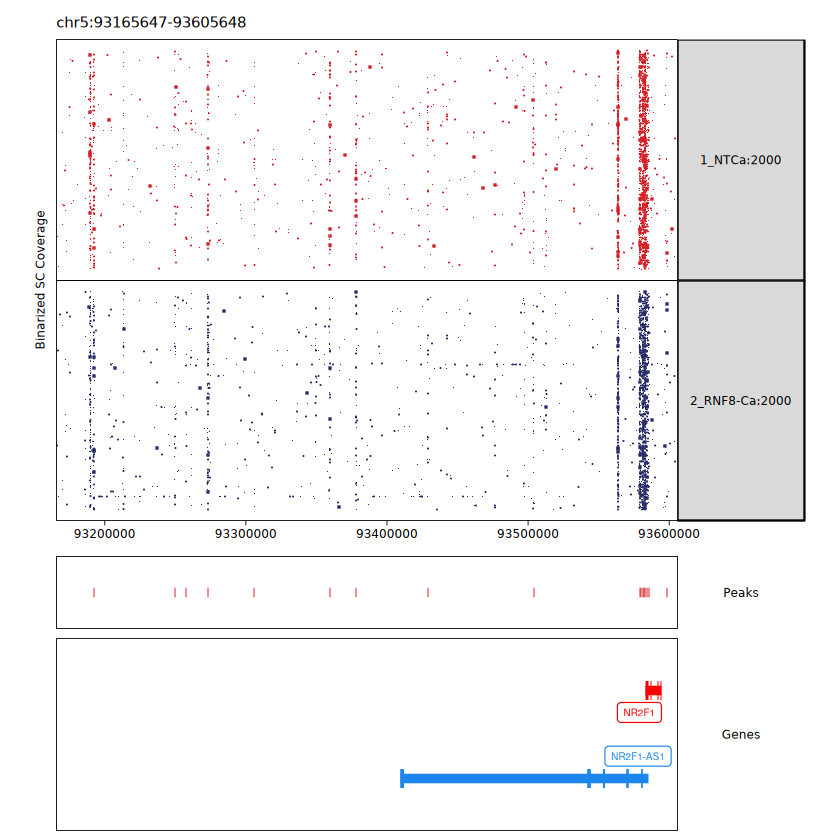

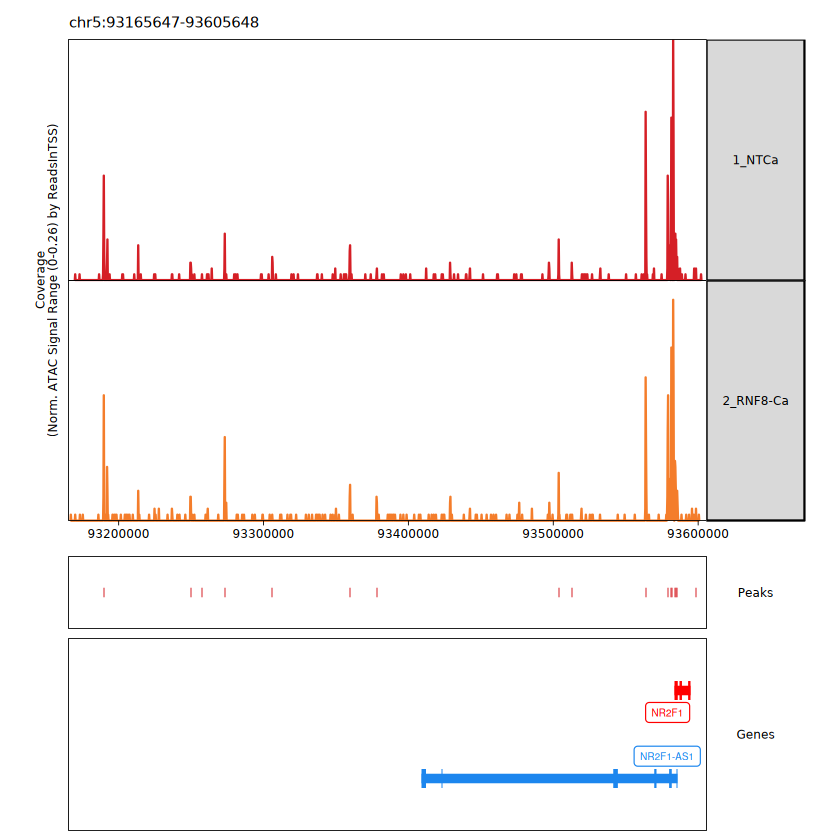

In [64]:
options(repr.plot.width = 7, repr.plot.height = 7)
grid::grid.newpage()
grid::grid.draw(sctrack$`NR2F1-AS1`)
grid::grid.newpage()
grid::grid.draw(bulktrack$`NR2F1-AS1`)

Warning message in geom_bar(aes(fill = sample), stat = "summary", fun.y = "mean", :
“Ignoring unknown parameters: `fun.y`”
No summary function supplied, defaulting to `mean_se()`


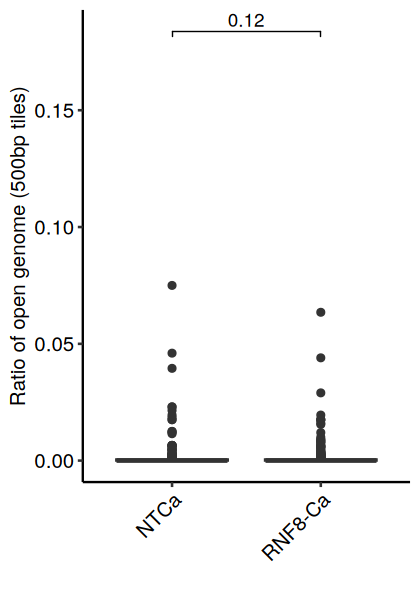

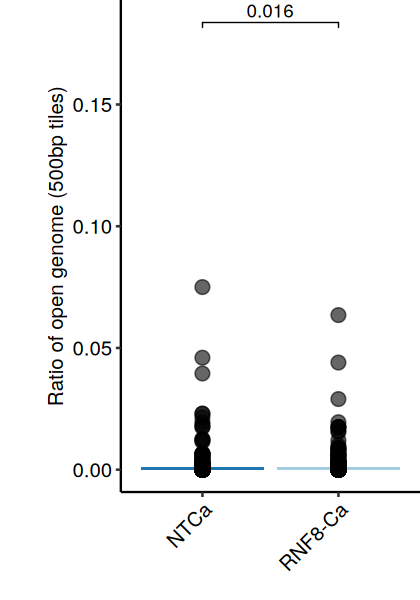

In [65]:
gene_coord = gene_annot %>% filter(symbol %in% 'TRPS1')
coord_idx = tile_region_meta %>% filter((seqnames %in% as.character(gene_coord$seqnames)) & (start > (gene_coord$start - 500)) & (start < (gene_coord$end + 500))) %>% pull(index) %>% as.numeric()
cell_idx = rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% c('1_NTCa', '2_RNF8-Ca'),])
TRPS1_mtx = tile_mtx[coord_idx, cell_idx]

## table of ratios of 0 to 1 for each 500 bp bin ##
df = data.frame('NTCa' = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '1_NTCa',])])/2000, 
'RNF8-Ca' = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '2_RNF8-Ca',])])/2000)
colnames(df) = c('NTCa', 'RNF8-Ca')

plot_df = pivot_longer(df, cols = everything(), names_to = 'sample', values_to = 'ratio')
plot_df$sample = factor(plot_df$sample, levels = c('NTCa', 'RNF8-Ca'))

options(repr.plot.width = 3.5, repr.plot.height = 5)
## plot 0 to 1 ratio boxplot ##
plot_df %>%  ggplot(aes(x = sample, y = ratio)) + geom_boxplot() + 
 stat_compare_means(comparisons = list(c('NTCa', 'RNF8-Ca')), method = 'wilcox', paired = T, label.y = 0.18) + xlab('') + 
 ylab('Ratio of open genome (500bp tiles)') + theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1))

plot_df %>% ggplot(aes(sample, ratio)) + geom_bar(aes(fill = sample), stat = 'summary', fun.y = 'mean', show.legend = FALSE) +
    geom_point(color = 'black', alpha = 0.6, size = 3.5, show.legend = FALSE) + theme_pubr() + stat_compare_means(comparisons = list(c('NTCa', 'RNF8-Ca')), method = 't.test', paired = T, label.y = 0.18) +
    theme(plot.margin = unit(c(0, 0, 0, 0.4), 'in'), plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + 
    xlab('') + ylab('Ratio of open genome (500bp tiles)') + scale_fill_brewer(palette = 'Paired', direction = -1) + scale_color_brewer(palette = 'Paired', direction = -1)

[1] 523

[1] 0.6496894

[1] 0.0635

[1] 0.075

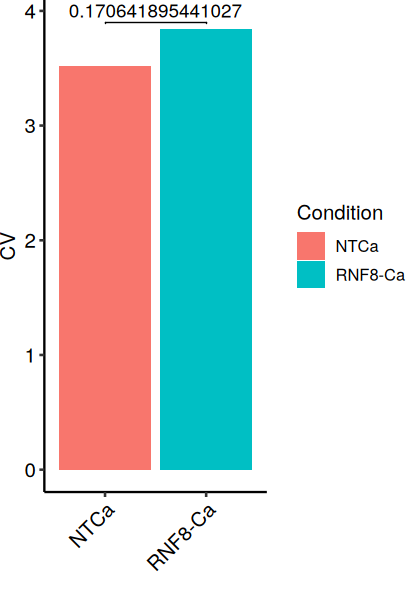

In [66]:
peaksums_RNF8_Ca = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '2_RNF8-Ca',])])
which.max(peaksums_RNF8_Ca)
which.max(peaksums_RNF8_Ca)/length(peaksums_RNF8_Ca) ## peak is at 99% starting from the left side of the gene
peaksums_RNF8_Ca[which.max(peaksums_RNF8_Ca)]/2000 ## open to close ratio

peaksums_NTCa = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '1_NTCa',])])
peaksums_NTCa[which.max(peaksums_RNF8_Ca)]/2000 ## open to close ratio

max_peak_df = data.frame(Condition = c('RNF8-Ca', 'RNF8-Ca', 'NTCa', 'NTCa'), chromatin = c('open', 'closed', 'open', 'closed'), pct = c(peaksums_RNF8_Ca[which.max(peaksums_RNF8_Ca)]/2000, 1 - peaksums_RNF8_Ca[which.max(peaksums_RNF8_Ca)]/2000, peaksums_NTCa[which.max(peaksums_RNF8_Ca)]/2000, 1 - peaksums_NTCa[which.max(peaksums_RNF8_Ca)]/2000))
max_peak_df$Condition = factor(max_peak_df$Condition, levels = c('NTCa', 'RNF8-Ca'))

stat.test = tibble(
  group1 = 'NTCa',
  group2 = 'RNF8-Ca',
  p.adj = chisq.test(matrix(c(max_peak_df$pct[1:2], max_peak_df$pct[3:4]), nrow = 2) * 2000)$p.value, ## chi-squared test
  y.position = 3.9
)

mtx = matrix(c(max_peak_df$pct[1:2], max_peak_df$pct[3:4]), nrow = 2) * 2000
df = data.frame(Condition = c('NTCa', 'RNF8-Ca'), CV = c(sd(c(rep(1, mtx[1,2]), c(rep(0, mtx[2,2]))))/mean(c(rep(1, mtx[1,2]), c(rep(0, mtx[2,2])))), sd(c(rep(1, mtx[1,1]), c(rep(0, mtx[2,1]))))/mean(c(rep(1, mtx[1,1]), c(rep(0, mtx[2,1]))))))
df$Condition = factor(df$Condition, levels = c('NTCa', 'RNF8-Ca'))
ggplot(df, aes(fill = Condition, y = CV, x = Condition)) + 
    geom_bar(position = "fill", stat = "identity", show.legend = T) + geom_bar(stat="identity") + theme_pubr() + stat_pvalue_manual(stat.test, label = 'p.adj', tip.length = 0.025, inherit.aes = F) +
    theme(legend.position = "right", axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + xlab('') + ylab('CV') + 
    theme(plot.margin = unit(c(0, 0, 0, 0), "in"), plot.title = element_text(hjust = 0.5, family = "Helvetica"), axis.text.x = element_text(family = "Helvetica"), axis.title = element_text(family = "Helvetica"), legend.text = element_text(family = "Helvetica"), legend.title = element_text(family = "Helvetica"))

saveRDS(df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/TRPS1_rnf8_ca_track_barplot_df.rds')
saveRDS(stat.test, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/TRPS1_rnf8_ca_track_barplot_test.rds')

In [78]:
CRISPRa_CVs_means[['RNF8-Ca']] %>% filter(abs(mean_gdmean_ctrlratio - 1) < 0.1) %>% arrange(desc(CV_gdCV_ctrlratio)) %>% head(20)

,gene,CV_ctrl,CV_gd,CV_gdCV_ctrlratio,mean_gdmean_ctrlratio,gene_status,p_val,mean_gd
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,PRKG1,1.473648,5.152954,3.496732,1.0635779,Increasing,7.314538e-218,0.9595122
2,OSBPL8,2.172199,5.874704,2.704497,1.0750420,Increasing,5.705278e-105,0.4489620
3,NAP1L1,2.244882,5.702351,2.540156,1.0832977,Increasing,1.462187e-96,0.4841991
4,NAA16,2.954516,5.731216,1.939816,1.0205783,Increasing,2.099056e-45,0.1882375
5,CAMSAP1,1.659610,2.964160,1.786058,1.0095883,Increasing,8.693299e-115,0.6302779
6,TUBGCP3,2.659055,4.662295,1.753365,1.0234253,Increasing,1.612223e-46,0.2616908
7,TUT4,2.632729,4.569618,1.735696,1.0137558,Increasing,2.083081e-46,0.2676100
8,FXN,2.847655,4.937131,1.733753,1.0942032,Increasing,4.950939e-40,0.2676045
9,E2F7,1.819602,2.954266,1.623578,1.0382862,Increasing,8.224944e-78,0.7169433


Warning message in geom_bar(aes(fill = sample), stat = "summary", fun.y = "mean", :
“Ignoring unknown parameters: `fun.y`”
No summary function supplied, defaulting to `mean_se()`


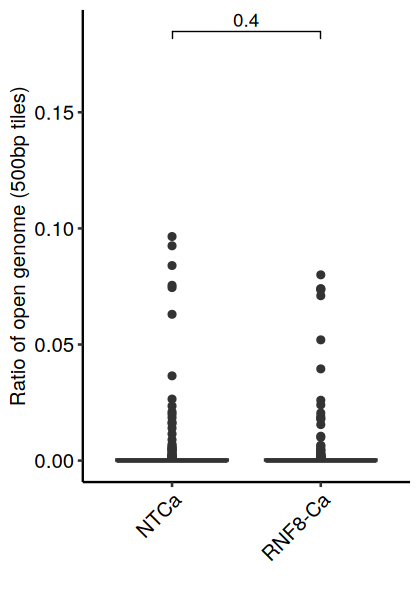

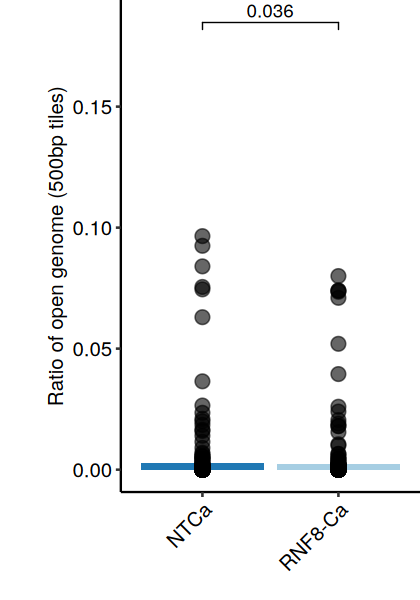

In [97]:
gene_coord = gene_annot %>% filter(symbol %in% 'NR2F1-AS1')
coord_idx = tile_region_meta %>% filter((seqnames %in% as.character(gene_coord$seqnames)) & (start > (gene_coord$start - 500)) & (start < (gene_coord$end + 500))) %>% pull(index) %>% as.numeric()
cell_idx = rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% c('1_NTCa', '2_RNF8-Ca'),])
PRKG1_mtx = tile_mtx[coord_idx, cell_idx]

## table of ratios of 0 to 1 for each 500 bp bin ##
df = data.frame('NTCa' = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '1_NTCa',])])/2000, 
'RNF8-Ca' = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '2_RNF8-Ca',])])/2000)
colnames(df) = c('NTCa', 'RNF8-Ca')

plot_df = pivot_longer(df, cols = everything(), names_to = 'sample', values_to = 'ratio')
plot_df$sample = factor(plot_df$sample, levels = c('NTCa', 'RNF8-Ca'))

options(repr.plot.width = 3.5, repr.plot.height = 5)
## plot 0 to 1 ratio boxplot ##
plot_df %>%  ggplot(aes(x = sample, y = ratio)) + geom_boxplot() + 
 stat_compare_means(comparisons = list(c('NTCa', 'RNF8-Ca')), method = 'wilcox', paired = T, label.y = 0.18) + xlab('') + 
 ylab('Ratio of open genome (500bp tiles)') + theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1))

plot_df %>% ggplot(aes(sample, ratio)) + geom_bar(aes(fill = sample), stat = 'summary', fun.y = 'mean', show.legend = FALSE) +
    geom_point(color = 'black', alpha = 0.6, size = 3.5, show.legend = FALSE) + theme_pubr() + stat_compare_means(comparisons = list(c('NTCa', 'RNF8-Ca')), method = 't.test', paired = T, label.y = 0.18) +
    theme(plot.margin = unit(c(0, 0, 0, 0.4), 'in'), plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + 
    xlab('') + ylab('Ratio of open genome (500bp tiles)') + scale_fill_brewer(palette = 'Paired', direction = -1) + scale_color_brewer(palette = 'Paired', direction = -1)

[1] 349

[1] 0.9830986

[1] 0.08

[1] 0.0965

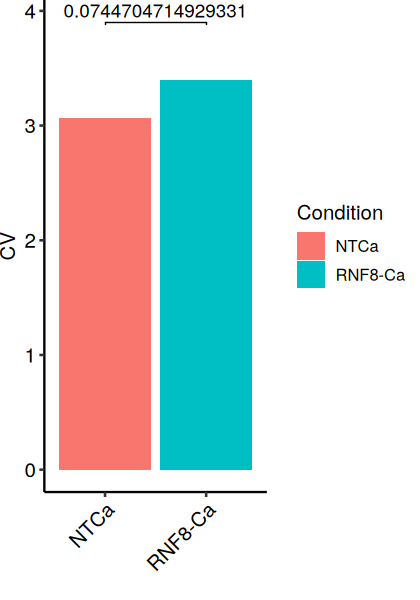

In [98]:
peaksums_RNF8_Ca = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '2_RNF8-Ca',])])
which.max(peaksums_RNF8_Ca)
which.max(peaksums_RNF8_Ca)/length(peaksums_RNF8_Ca) ## peak is at 99% starting from the left side of the gene
peaksums_RNF8_Ca[which.max(peaksums_RNF8_Ca)]/2000 ## open to close ratio

peaksums_NTCa = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '1_NTCa',])])
peaksums_NTCa[which.max(peaksums_RNF8_Ca)]/2000 ## open to close ratio

max_peak_df = data.frame(Condition = c('RNF8-Ca', 'RNF8-Ca', 'NTCa', 'NTCa'), chromatin = c('open', 'closed', 'open', 'closed'), pct = c(peaksums_RNF8_Ca[which.max(peaksums_RNF8_Ca)]/2000, 1 - peaksums_RNF8_Ca[which.max(peaksums_RNF8_Ca)]/2000, peaksums_NTCa[which.max(peaksums_RNF8_Ca)]/2000, 1 - peaksums_NTCa[which.max(peaksums_RNF8_Ca)]/2000))
max_peak_df$Condition = factor(max_peak_df$Condition, levels = c('NTCa', 'RNF8-Ca'))

stat.test = tibble(
  group1 = 'NTCa',
  group2 = 'RNF8-Ca',
  p.adj = chisq.test(matrix(c(max_peak_df$pct[1:2], max_peak_df$pct[3:4]), nrow = 2) * 2000)$p.value, ## chi-squared test
  y.position = 3.9
)

mtx = matrix(c(max_peak_df$pct[1:2], max_peak_df$pct[3:4]), nrow = 2) * 2000
df = data.frame(Condition = c('NTCa', 'RNF8-Ca'), CV = c(sd(c(rep(1, mtx[1,2]), c(rep(0, mtx[2,2]))))/mean(c(rep(1, mtx[1,2]), c(rep(0, mtx[2,2])))), sd(c(rep(1, mtx[1,1]), c(rep(0, mtx[2,1]))))/mean(c(rep(1, mtx[1,1]), c(rep(0, mtx[2,1]))))))
df$Condition = factor(df$Condition, levels = c('NTCa', 'RNF8-Ca'))
ggplot(df, aes(fill = Condition, y = CV, x = Condition)) + 
    geom_bar(position = "fill", stat = "identity", show.legend = T) + geom_bar(stat="identity") + theme_pubr() + stat_pvalue_manual(stat.test, label = 'p.adj', tip.length = 0.025, inherit.aes = F) +
    theme(legend.position = "right", axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + xlab('') + ylab('CV') + 
    theme(plot.margin = unit(c(0, 0, 0, 0), "in"), plot.title = element_text(hjust = 0.5, family = "Helvetica"), axis.text.x = element_text(family = "Helvetica"), axis.title = element_text(family = "Helvetica"), legend.text = element_text(family = "Helvetica"), legend.title = element_text(family = "Helvetica"))

#saveRDS(df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/TRPS1_rnf8_ca_track_barplot_df.rds')
#saveRDS(stat.test, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/TRPS1_rnf8_ca_track_barplot_test.rds')

#### MIS18A-Ca ####

In [67]:
CRISPRa_CVs_means[['MIS18A-Ca']] %>% filter(abs(mean_gdmean_ctrlratio - 1) < 0.01) %>% arrange(desc(CV_gdCV_ctrlratio)) %>% head()

,gene,CV_ctrl,CV_gd,CV_gdCV_ctrlratio,mean_gdmean_ctrlratio,gene_status,p_val,mean_gd
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,PPP4R2,2.966775,8.799597,2.966048,1.0082052,Increasing,7.768072e-85,0.2282074
2,ANKHD1,1.735487,3.664885,2.111733,0.9971388,Increasing,6.530335e-150,0.6059635
3,NSUN2,3.420983,7.172959,2.096754,0.9978166,Increasing,5.802338e-42,0.2090216
4,EIF3E,2.981099,4.833190,1.621278,1.0038002,Increasing,2.682336e-28,0.1713984
5,ERICH1,2.192944,3.423488,1.561138,1.0043531,Increasing,5.937093e-43,0.4531910
6,FOCAD,2.266147,3.537179,1.560878,0.9976578,Increasing,1.759054e-40,0.2976821


In [68]:
sctrack <- plotBrowserTrack(ArchRProj = subset_txnhet_archr_macs2_project, groupBy = "renamed_combined_lanes_samples", 
    plotSummary = c("scTrack", "featureTrack", "loopTrack", "geneTrack"), geneSymbol = c('PPP4R2', 'NSUN2'), 
    useGroups = c('1_NTCa', '2_MIS18A-Ca'), upstream = 10000, downstream = 80000, scCellsMax = 2000)
    
bulktrack <- plotBrowserTrack(ArchRProj = subset_txnhet_archr_macs2_project, groupBy = "renamed_combined_lanes_samples", 
    plotSummary = c("bulkTrack", "featureTrack", "loopTrack", "geneTrack"), geneSymbol = c('PPP4R2', 'NSUN2'), 
    useGroups = c('1_NTCa', '2_MIS18A-Ca'), upstream = 10000, downstream = 80000, scCellsMax = 2000)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-32f805161fa358-Date-2025-03-04_Time-14-09-11.952825.log
If there is an issue, please report to github with logFile!

2025-03-04 14:09:12.060649 : Validating Region, 0.002 mins elapsed.



GRanges object with 2 ranges and 2 metadata columns:
      seqnames            ranges strand |     gene_id      symbol
         <Rle>         <IRanges>  <Rle> | <character> <character>
  [1]     chr3 72996785-73069199      + |      151987      PPP4R2
  [2]     chr5   6599239-6633291      - |       54888       NSUN2
  -------
  seqinfo: 24 sequences from hg38 genome


2025-03-04 14:09:12.142787 : Adding SC Tracks (1 of 2), 0.003 mins elapsed.



2025-03-04 14:09:13.490429 : Adding Feature Tracks (1 of 2), 0.026 mins elapsed.

2025-03-04 14:09:13.577149 : Adding Gene Tracks (1 of 2), 0.027 mins elapsed.

2025-03-04 14:09:13.881346 : Plotting, 0.032 mins elapsed.

2025-03-04 14:09:14.277016 : Adding SC Tracks (2 of 2), 0.039 mins elapsed.

2025-03-04 14:09:15.640157 : Adding Feature Tracks (2 of 2), 0.061 mins elapsed.

2025-03-04 14:09:15.724784 : Adding Gene Tracks (2 of 2), 0.063 mins elapsed.

2025-03-04 14:09:16.059756 : Plotting, 0.068 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-32f805161fa358-Date-2025-03-04_Time-14-09-11.952825.log

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-32f8054a748f10-Date-2025-03-04_Time-14-09-16.914156.log
If there is an issue, please report to github with logFile!

2025-03-04 14:09:17.056836 : Validating Region, 0.002 mins elapsed.



GRanges object with 2 ranges and 2 metadata columns:
      seqnames            ranges strand |     gene_id      symbol
         <Rle>         <IRanges>  <Rle> | <character> <character>
  [1]     chr3 72996785-73069199      + |      151987      PPP4R2
  [2]     chr5   6599239-6633291      - |       54888       NSUN2
  -------
  seqinfo: 24 sequences from hg38 genome


2025-03-04 14:09:17.18582 : Adding Bulk Tracks (1 of 2), 0.005 mins elapsed.

2025-03-04 14:09:19.425509 : Adding Feature Tracks (1 of 2), 0.042 mins elapsed.

2025-03-04 14:09:19.515276 : Adding Gene Tracks (1 of 2), 0.043 mins elapsed.

2025-03-04 14:09:19.840355 : Plotting, 0.049 mins elapsed.

2025-03-04 14:09:20.352304 : Adding Bulk Tracks (2 of 2), 0.057 mins elapsed.

2025-03-04 14:09:22.240345 : Adding Feature Tracks (2 of 2), 0.089 mins elapsed.

2025-03-04 14:09:22.326545 : Adding Gene Tracks (2 of 2), 0.09 mins elapsed.

2025-03-04 14:09:22.653239 : Plotting, 0.096 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotBrowserTrack-32f8054a748f10-Date-2025-03-04_Time-14-09-16.914156.log



In [69]:
pdf('/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/PPP4R2_mis18a_ca_track.pdf', width = 7, height = 7)
grid::grid.newpage()
grid::grid.draw(sctrack$PPP4R2)
dev.off()

pdf 
  2

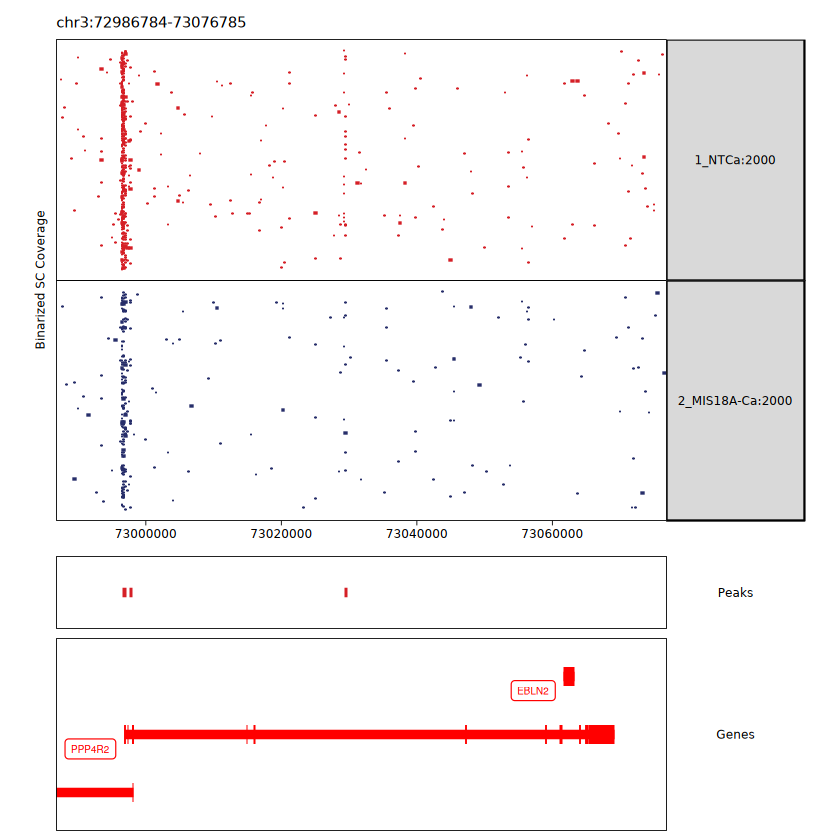

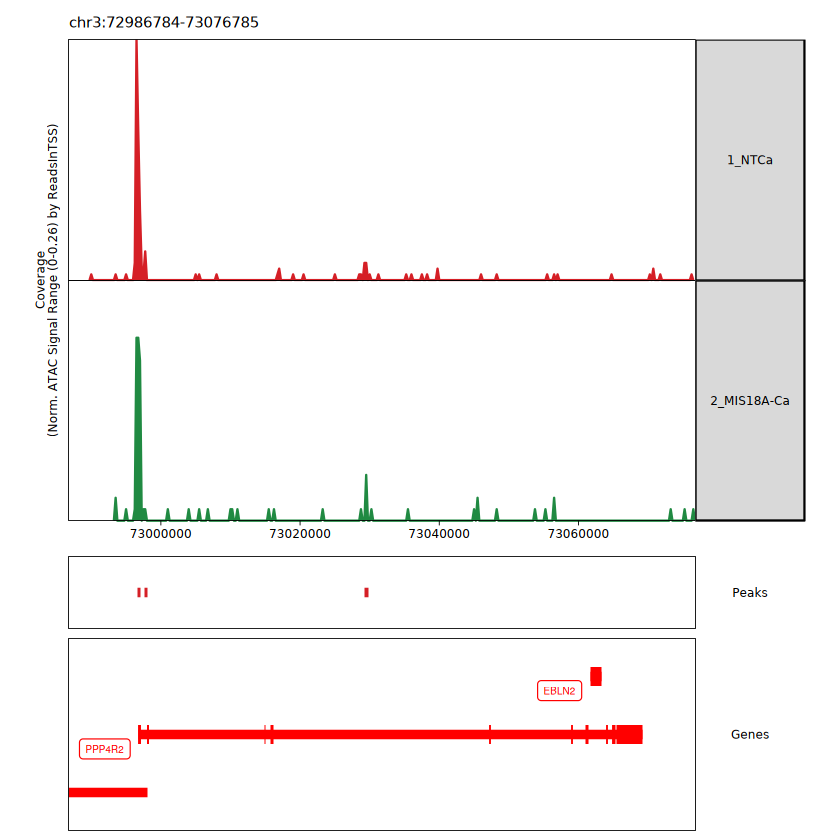

In [70]:
options(repr.plot.width = 7, repr.plot.height = 7)
grid::grid.newpage()
grid::grid.draw(sctrack$PPP4R2)
grid::grid.newpage()
grid::grid.draw(bulktrack$PPP4R2)

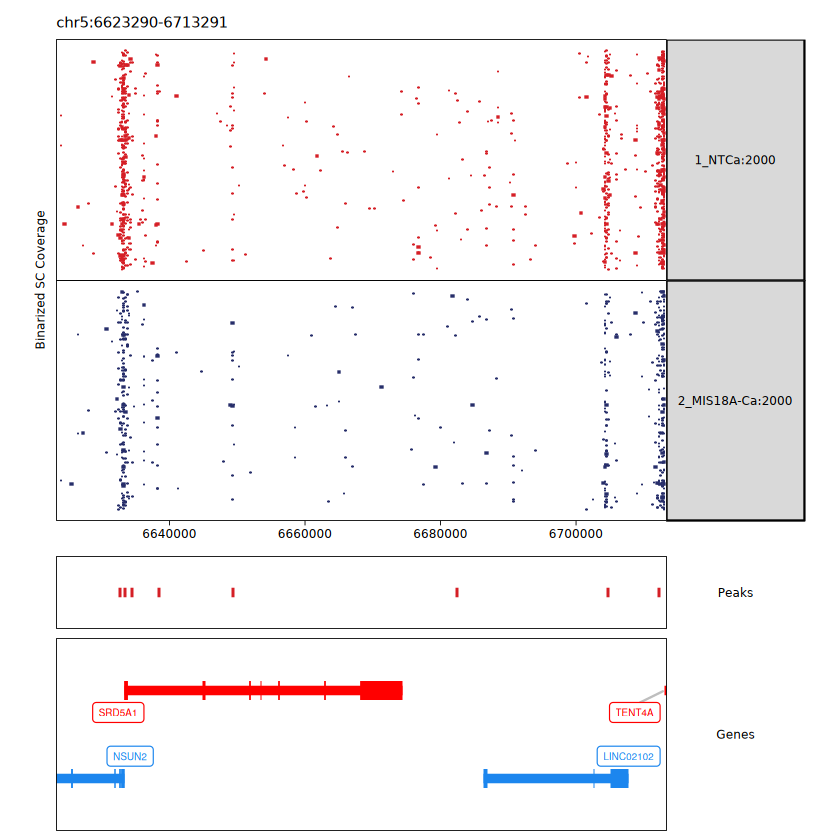

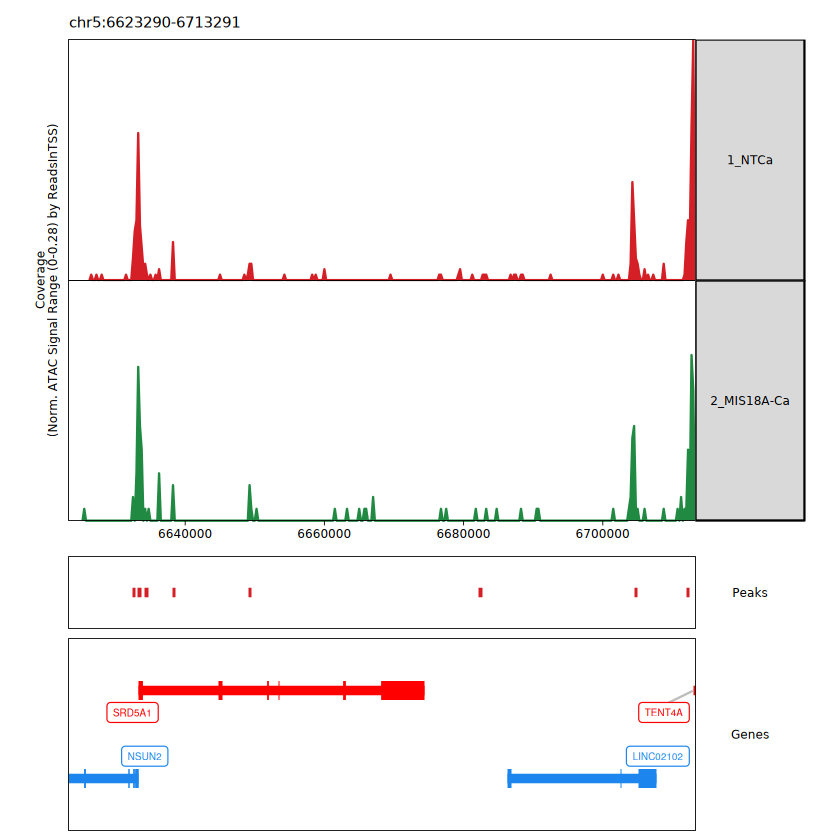

In [71]:
grid::grid.newpage()
grid::grid.draw(sctrack$NSUN2)
grid::grid.newpage()
grid::grid.draw(bulktrack$NSUN2)

Warning message in geom_bar(aes(fill = sample), stat = "summary", fun.y = "mean", :
“Ignoring unknown parameters: `fun.y`”
No summary function supplied, defaulting to `mean_se()`


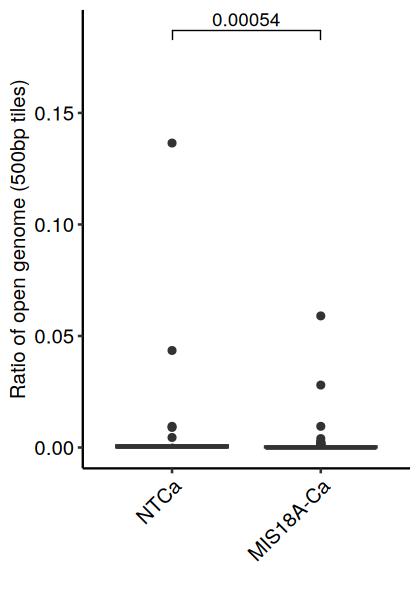

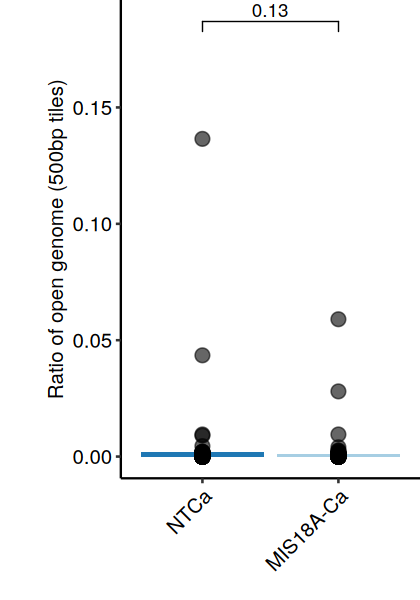

In [72]:
gene_coord = gene_annot %>% filter(symbol %in% 'PPP4R2')
coord_idx = tile_region_meta %>% filter((seqnames %in% as.character(gene_coord$seqnames)) & (start > (gene_coord$start - 500)) & (start < (gene_coord$end + 500))) %>% pull(index) %>% as.numeric()
cell_idx = rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% c('1_NTCa', '2_MIS18A-Ca'),])
PPP4R2_mtx = tile_mtx[coord_idx, cell_idx]

## table of ratios of 0 to 1 for each 500 bp bin ##
df = data.frame('NTCa' = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '1_NTCa',])])/2000, 
'MIS18A-Ca' = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '2_MIS18A-Ca',])])/2000)
colnames(df) = c('NTCa', 'MIS18A-Ca')

plot_df = pivot_longer(df, cols = everything(), names_to = 'sample', values_to = 'ratio')
plot_df$sample = factor(plot_df$sample, levels = c('NTCa', 'MIS18A-Ca'))

options(repr.plot.width = 3.5, repr.plot.height = 5)
## plot 0 to 1 ratio boxplot ##
plot_df %>%  ggplot(aes(x = sample, y = ratio)) + geom_boxplot() + 
 stat_compare_means(comparisons = list(c('NTCa', 'MIS18A-Ca')), method = 'wilcox', paired = T, label.y = 0.18) + xlab('') + 
 ylab('Ratio of open genome (500bp tiles)') + theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1))

plot_df %>% ggplot(aes(sample, ratio)) + geom_bar(aes(fill = sample), stat = 'summary', fun.y = 'mean', show.legend = FALSE) +
    geom_point(color = 'black', alpha = 0.6, size = 3.5, show.legend = FALSE) + theme_pubr() + stat_compare_means(comparisons = list(c('NTCa', 'MIS18A-Ca')), method = 't.test', paired = T, label.y = 0.18) +
    theme(plot.margin = unit(c(0, 0, 0, 0.4), 'in'), plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + 
    xlab('') + ylab('Ratio of open genome (500bp tiles)') + scale_fill_brewer(palette = 'Paired', direction = -1) + scale_color_brewer(palette = 'Paired', direction = -1)

[1] 1

[1] 0.006802721

[1] 0.059

[1] 0.1365

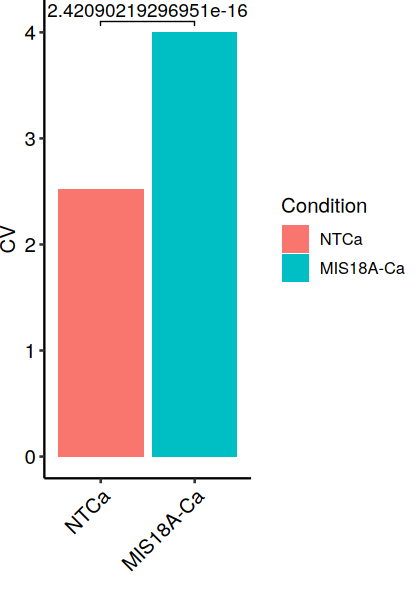

In [73]:
peaksums_MIS18A_Ca = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '2_MIS18A-Ca',])])
which.max(peaksums_MIS18A_Ca)
which.max(peaksums_MIS18A_Ca)/length(peaksums_MIS18A_Ca) ## peak is at 99% starting from the left side of the gene
peaksums_MIS18A_Ca[which.max(peaksums_MIS18A_Ca)]/2000 ## open to close ratio

peaksums_NTCa = rowSums(tile_mtx[coord_idx, rownames(tile_cell_meta[tile_cell_meta$renamed_combined_lanes_samples %in% '1_NTCa',])])
peaksums_NTCa[which.max(peaksums_MIS18A_Ca)]/2000 ## open to close ratio

max_peak_df = data.frame(Condition = c('MIS18A-Ca', 'MIS18A-Ca', 'NTCa', 'NTCa'), chromatin = c('open', 'closed', 'open', 'closed'), pct = c(peaksums_MIS18A_Ca[which.max(peaksums_MIS18A_Ca)]/2000, 1 - peaksums_MIS18A_Ca[which.max(peaksums_MIS18A_Ca)]/2000, peaksums_NTCa[which.max(peaksums_MIS18A_Ca)]/2000, 1 - peaksums_NTCa[which.max(peaksums_MIS18A_Ca)]/2000))
max_peak_df$Condition = factor(max_peak_df$Condition, levels = c('NTCa', 'MIS18A-Ca'))

stat.test = tibble(
  group1 = 'NTCa',
  group2 = 'MIS18A-Ca',
  p.adj = chisq.test(matrix(c(max_peak_df$pct[1:2], max_peak_df$pct[3:4]), nrow = 2) * 2000)$p.value, ## chi-squared test
  y.position = 4.1
)

mtx = matrix(c(max_peak_df$pct[1:2], max_peak_df$pct[3:4]), nrow = 2) * 2000
df = data.frame(Condition = c('NTCa', 'MIS18A-Ca'), CV = c(sd(c(rep(1, mtx[1,2]), c(rep(0, mtx[2,2]))))/mean(c(rep(1, mtx[1,2]), c(rep(0, mtx[2,2])))), sd(c(rep(1, mtx[1,1]), c(rep(0, mtx[2,1]))))/mean(c(rep(1, mtx[1,1]), c(rep(0, mtx[2,1]))))))
df$Condition = factor(df$Condition, levels = c('NTCa', 'MIS18A-Ca'))
ggplot(df, aes(fill = Condition, y = CV, x = Condition)) + 
    geom_bar(position = "fill", stat = "identity", show.legend = T) + geom_bar(stat="identity") + theme_pubr() + stat_pvalue_manual(stat.test, label = 'p.adj', tip.length = 0.025, inherit.aes = F) +
    theme(legend.position = "right", axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) + xlab('') + ylab('CV') + 
    theme(plot.margin = unit(c(0, 0, 0, 0), "in"), plot.title = element_text(hjust = 0.5, family = "Helvetica"), axis.text.x = element_text(family = "Helvetica"), axis.title = element_text(family = "Helvetica"), legend.text = element_text(family = "Helvetica"), legend.title = element_text(family = "Helvetica"))

saveRDS(df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/PPP4R2_MIS18A_ca_track_barplot_df.rds')
saveRDS(stat.test, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/PPP4R2_MIS18A_ca_track_barplot_test.rds')